# Uncertainty Analysis Using GP, NLM, and BaCOUn

### Analysis of the paper: [BaCOUn: Bayesian Classifers with Out-of-Distribution Uncertainty](https://arxiv.org/pdf/2007.06096.pdf)



**Team Members:** Qiang Fei, Catharine Wu, Ruochen Zhao, Silin Zou

## Table of Contents

1. Problem Statement
2. Existing Work
3. Contribution
4. Data (Toy data + Mnist)
5. Experiments (GP, NLM, BaCOUn)
6. Evaluation and Interpretation
7. Future Work
8. References

In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.manifold import TSNE
import sklearn.gaussian_process as gp
import time
from sklearn import metrics

## 1. Problem Statement

Traditional classification models focus on producing highly confident models that fit the observed data perfectly, which results in high sensitivity toward data shifts. However, in high-risk domains, we’d like the models to only be confident when we have enough domain knowledge (abundant data) and provide appropriate uncertainty when we don’t so we know when to bring in human expertise to make effective decisions. In this project, we'll experiment different models on different types of data to explore model sensitivity and efficiency on providing uncertainties and distinguishing between aleatoric uncertainty and epistemic uncertainty.

## 2. Existing Work

In the paper, the authors mentioned a few existing attempts to solve the problem. 

First, some non-bayesian approaches have been proposed to model OOD uncertainty, none of which was able to provide decomposition between aleatoric uncertainty and epistemic uncertainty. And the classifiers tend to be over-confident about OOD points. 

Both Gaussian Processes(GP) and Bayesian Neural Networks(BNN) are common methods to provide predictive uncertainty for classification problems. But since GP cannot scale with the number of observations, and inference for large BNNs are still challenging, Neural Linear Models(NLM) becomes a popular replacement as it only uses the weights from the last hidden layer. But unfortunately, just as BNNs, traditional NLM models are also unable to model OOD uncertainty due to its structure of objectives. Since OOD detection is not incorporated in the objective for model training, the final result cannot capture the uncertainty raised from OOD distributions. 

## 3. Contribution

In regards to the issues of the aforementioned moedels, Bayesian Classifiers with Out-of-Distribution Uncertainty (BaCOUn) was developed to address this problem. BaCOUn starts with generating OOD samples from data boundaries and train a neural network classifier to distinguish the K+1 classes which include the original K classes and the OOD class. Then, extract the feature map from the last hidden layer and fit a Bayesian logistic regression model on these features. 

Our contributions in the project are as follows: First, we build 3 classifiers, GP, NLM, and BaCOUn and fit them on different datasets to evaluate their performance. In particular, we inspect their sensitivity and abilities to capture OOD uncertainty for different OOD shapes. Then, we'll discuss their merits and usages.

## 4. Data Generation

In this section, we'll generate different types of datasets with different out-of-distribution (OOD) shapes.

### 4.1. Well-Seperated and Linearly-Seperable

Here, we are insterested in exploring the effect of different OOD shapes on linearly-seperable data.

In [2]:
# generate 3 classes
X, y = datasets.make_blobs(n_samples=[200,200,200], 
                           centers=[[0, 3], [-3, -3], [3, -3]], 
                           cluster_std=0.9, 
                           n_features=2, 
                           random_state=0)

In [3]:
# generate OOD
np.random.seed(0)
r = 6.8 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append((r + random.random())*np.cos(angle))
    x2.append(-.5+(r + random.random())*np.sin(angle))

#### a) ODD: complete ring

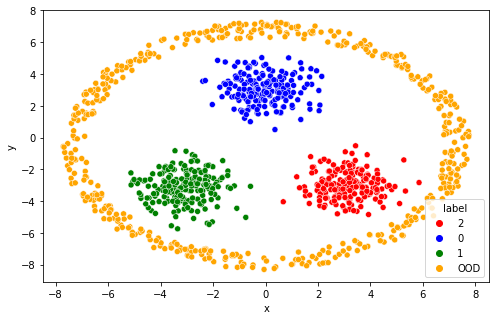

In [4]:
df1a = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df1a_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df1a = df1a.append(df1a_ood, ignore_index=True)

plt.figure(figsize=[8,5])
sns.scatterplot(data=df1a, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

#### b) OOD: semicircle

In [5]:
# generate OOD
np.random.seed(0)
r = 6 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,np.pi)
    x1.append((r + random.random())*np.cos(angle))
    x2.append((r + random.random())*np.sin(angle))

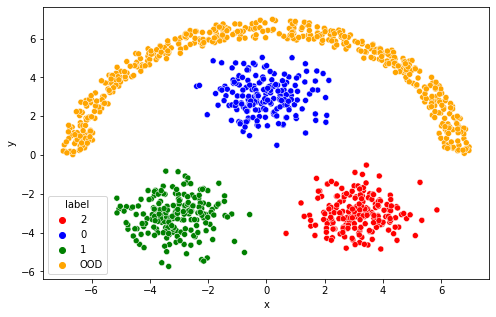

In [6]:
df1b = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df1b_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df1b = df1b.append(df1b_ood, ignore_index=True)

plt.figure(figsize=[8,5])
sns.scatterplot(data=df1b, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

#### c) Incomplete OOD (w/ holes)

In [7]:
# generate OOD
np.random.seed(0)
r = 6.8 # radius
x1, x2 = [], []
angles = np.random.uniform(0,2 * np.pi, 50)

for _ in range(500):
    # random angle
    angle = np.random.choice(angles)
    x1.append((r + random.random())*np.cos(angle))
    x2.append(-.5+(r + random.random())*np.sin(angle))

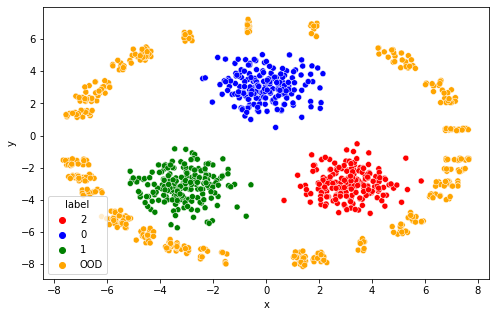

In [8]:
df1c = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df1c_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD')).sample(500, random_state = 0)
df1c = df1c.append(df1c_ood, ignore_index=True)

plt.figure(figsize=[8,5])
sns.scatterplot(data=df1c, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

### 4.2. Well-Seperated and Linearly-Seperable, but clusters are far away from each other

We are interested in exploring whether the points in between far-away clusters should be considered as OOD.

In [9]:
# generate 3 classes
X, y = datasets.make_blobs(n_samples=[200,200,200], 
                           centers=[[0, 6], [-6, -6], [6, -6]], 
                           cluster_std=1, 
                           n_features=2, 
                           random_state=0)

#### a) one ODD boundary
Between-cluster points are not OOD.

In [10]:
# generate OOD
np.random.seed(0)
r = 11.5 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append((r + random.random())*np.cos(angle))
    x2.append(-1+(r + random.random())*np.sin(angle))

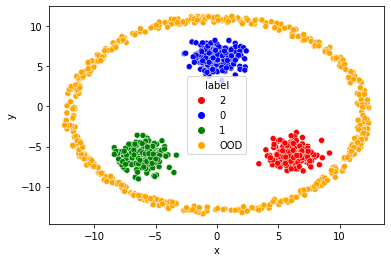

In [11]:
df2a = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df2a_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df2a = df2a.append(df2a_ood, ignore_index=True)

sns.scatterplot(data=df2a, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

#### b) three ODD boundary
Between-cluster points are OOD.

In [12]:
# generate OOD
np.random.seed(42)
r = 3.5 # radius
cx1, cx2, cx3 = 0, -6, 6
cy1, cy2, cy3 = 6, -6, -6
x1, x2 = [], []
for _ in range(500//3):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append(cx1 + (r + random.random())*np.cos(angle))
    x1.append(cx2 + (r + random.random())*np.cos(angle))
    x1.append(cx3 + (r + random.random())*np.cos(angle))
    x2.append(cy1 + (r + random.random())*np.sin(angle))
    x2.append(cy2 + (r + random.random())*np.sin(angle))
    x2.append(cy3 + (r + random.random())*np.sin(angle))

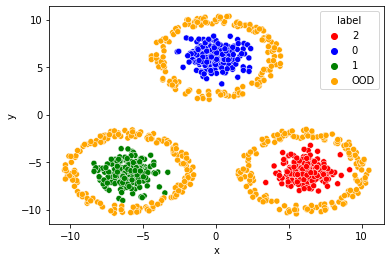

In [13]:
df2b = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df2b_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df2b = df2b.append(df2b_ood, ignore_index=True)

sns.scatterplot(data=df2b, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

### 4.3. Not Well-Seperated
Here we explore the effect of overlapping clusters.

In [14]:
# generate 3 classes
X, y = datasets.make_blobs(n_samples=[200,200,200], 
                           centers=[[0, 1], [-1, -1], [1, -1]], 
                           cluster_std=1, 
                           n_features=2, 
                           random_state=0)

In [15]:
# generate OOD
np.random.seed(42)
r = 4.5 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append((r + random.random())*np.cos(angle))
    x2.append((r + random.random())*np.sin(angle))

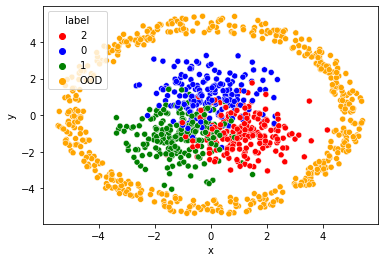

In [16]:
df3 = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df3_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df3 = df3.append(df3_ood, ignore_index=True)

sns.scatterplot(data=df3, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

### 4.4. Well-Seperated by non-linear boundary

In [17]:
X, y = datasets.make_moons(n_samples=600, shuffle=True, noise=0.1, random_state=0)

In [18]:
# generate OOD
np.random.seed(0)
r = 2 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append(.5+(r + random.random())*np.cos(angle))
    x2.append(.3+(r + random.random())/1.5*np.sin(angle))

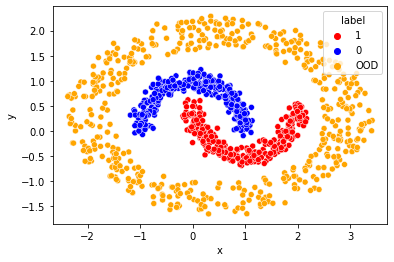

In [19]:
df4 = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df4_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df4 = df4.append(df4_ood, ignore_index=True)

sns.scatterplot(data=df4, x="x", y="y", hue="label", palette=["red", "blue", "orange"]);

### 4.5. MNIST
Now we use a real dataset: MNIST, we take samples from digits 0,1,2 as in-distribution data, and sample from the digit 3 as OOD.

In [20]:
# Load data from https://www.openml.org/d/554
X, y = datasets.fetch_openml('mnist_784', version=1, return_X_y=True)

In [21]:
# Pick out 3 classes of digits: 0, 1, 2 and take a subset of samples as in-distribution points
X_0, y_0 = X[(y == '0')][:500], y[(y == '0')][:500].astype(int)
X_1, y_1 = X[(y == '1')][:500], y[(y == '1')][:500].astype(int)
X_2, y_2 = X[(y == '2')][:500], y[(y == '2')][:500].astype(int)
# sample from digit 3 as OODs
X_ood, y_ood = X[(y == '3')][:500], ['OOD'] * 500

In [22]:
len(np.concatenate((X_0, X_1, X_2)))

1500

In [23]:
# combine data
X_mnist = np.concatenate((X_0, X_1, X_2, X_ood))
y_mnist = np.concatenate((y_0, y_1, y_2, y_ood))

## 5. Experiment

### 5.1 Gaussian Processes (GP)

In this section, we explored applying Gaussian Processes (GP) to our data. The process involves first training a GP that fits training data (without OOD data), then predicting on the entire dataframe (with OOD data) to see how GP handles the OOD data and whether it returns high uncertainties. We also tried experimenting with different kernel functions and parameters.

In order to derive probabilities, we used the following formula:
$$U(x) = 1- P(\hat{x}|x)$$
i.e., we find the probability associated with the predicted class, and use 'one minus that probability' as our uncertainty measure.

In [24]:
#Helper function for deriving uncertainty from classification probabilities
def uncertainty(pred_proba):
    most_probable = np.max(pred_proba, axis = 1)
    return 1-most_probable
    
#define the gaussian process model
def gaussian(df, kernel, title, l = 16, no_ood = True):
    start = time.time()
    #first get train x and train y (without including OOD data)
    if no_ood:
        train_df = df[df.label!='OOD']
        train_y = np.array(list(train_df.label))
    else:
        train_df = df
        train_y = df.label.replace('OOD', -1).values
    train_x = train_df.drop(columns = ['label']).values
    #initialize model
    model = gp.GaussianProcessClassifier(kernel=kernel)
    model.fit(train_x, train_y)
    params = model.kernel_.get_params()
    #predict with OOD data
    whole_y = df.label.replace('OOD', -1).values
    whole_x = df.drop(columns = ['label']).values
    y_pred = model.predict(whole_x)
    
    fig, ax = plt.subplots(1, 2, figsize = (15, 5))
    #plot the predictions
    df_new = pd.DataFrame(dict(x=whole_x[:,0], y=whole_x[:,1], label=y_pred))
    sns.scatterplot(data=df_new, x="x", y="y", hue="label", ax = ax[0]);
    
    #Plot the uncertainties
    x = np.linspace(-l,l,1000).reshape(-1,1)
    y = np.linspace(-l,l,1000).reshape(-1,1)
    X,Y = np.meshgrid(x,y)
    Z = np.zeros((1000,1000))

    for i in range(1000):
        xy = np.concatenate((X[i].reshape(-1,1), Y[i].reshape(-1,1)), axis = 1)
        y_pred_new = model.predict_proba(xy)
        Z[i] = uncertainty(y_pred_new)

    ax[1].pcolormesh(X, Y, Z, shading='gouraud', vmin=Z.min(), vmax=Z.max())
    ax[1].scatter(df[df.label==0].x, df[df.label==0].y, color = 'blue')
    ax[1].scatter(df[df.label==1].x, df[df.label==1].y, color = 'green')
    ax[1].scatter(df[df.label==2].x, df[df.label==2].y, color = 'red')
    ax[1].scatter(df[df.label=='OOD'].x, df[df.label=='OOD'].y, color = 'yellow')
    ax[0].set_title('{} predictions'.format(title))
    ax[1].set_title('{} uncertainties'.format(title))
    print('execution time: {} mins'.format((time.time()-start)/60))
    return model, ax

Testing case 1a: OOD ring.

Firstly, we tried this case with different kernel functions, including Matern, Rational Quadratic, and the more widely-applied RBF kernel. Kernel functions represent covariance in a GP model. We expect to see an impact of changing the kernel on the model, since it changes our priors.

execution time: 2.0494640350341795 mins
execution time: 2.6720855514208477 mins
execution time: 1.8506725827852886 mins


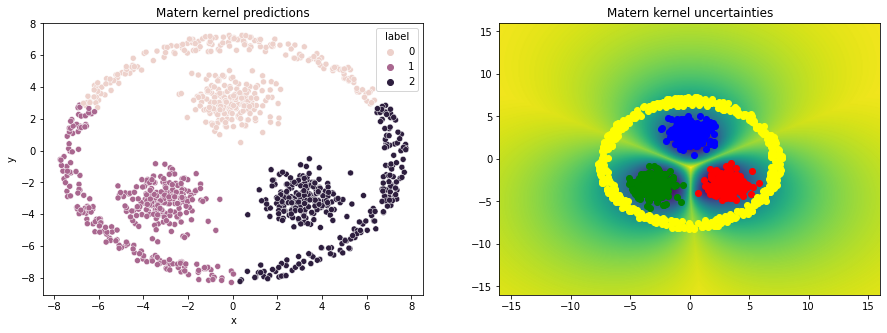

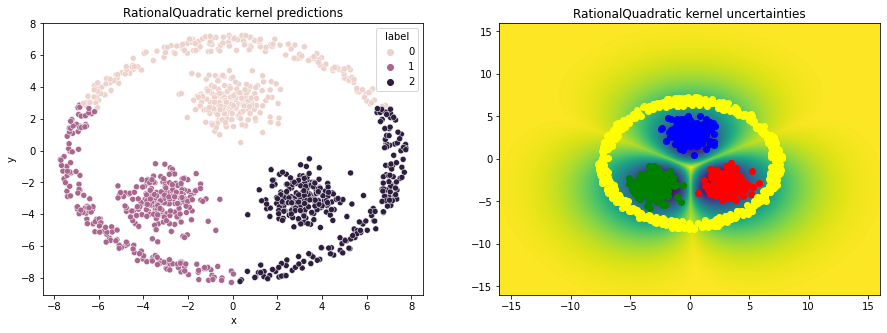

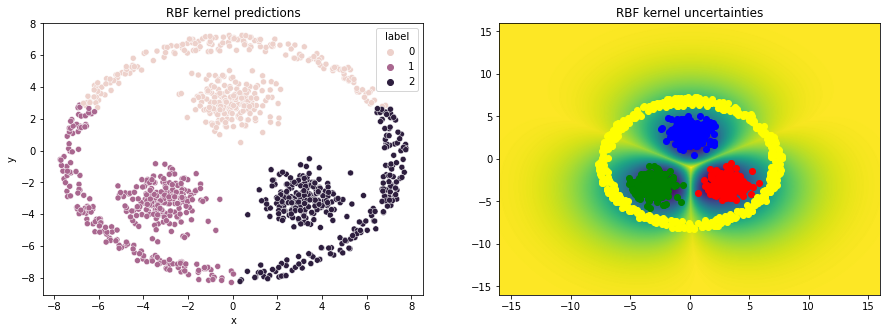

In [25]:
#adjust kernel parameters
kernel1 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.Matern(length_scale=1.0, nu=1.5)
model1a1, ax1 = gaussian(df1a, kernel1, 'Matern kernel')
kernel2 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RationalQuadratic(length_scale=1.0, alpha=1.5)
model1a2, ax2 = gaussian(df1a, kernel2, 'RationalQuadratic kernel')
kernel3 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model1a2, ax3 = gaussian(df1a, kernel3, 'RBF kernel')
plt.show()

As we could see, adjusting the kernel did result in differences of the radiation of decay for the uncertainties. For Matern Kernel, we saw a slower decay when data points get further away from the training data. However, the changes did not affect the overall shape of both the predictions and the uncertainties.

Below is an experiment to train on OOD data as a class as well. As we could see, the result is not much different from the rest of the graphs, while the OOD class is considered another class and uncertainties follow closely to its shape, which doesn't cover the whole domain.

Another thing to note in this case is that, when we added one more class (OOD), the training time went from 2 minutes to 7 minutes. As many have pointed out, GP is not very scalable when number of classes increase.

execution time: 7.2097424825032554 mins


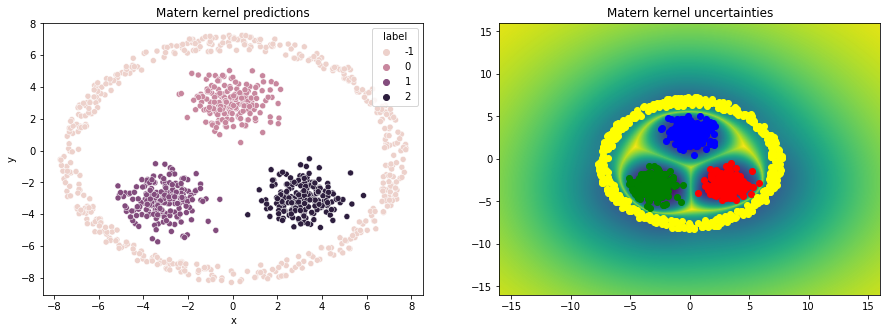

In [26]:
kernel1 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.Matern(length_scale=1.0, nu=1.5)
model1a1, ax1 = gaussian(df1a, kernel1, 'Matern kernel', no_ood = False)

Testing case 1b

We have also tested the different parameters and kernels on the following cases. The previous conclusions remain valid. Therefore, to make the report more succinct and comparable, we would focus on the case with an RBF kernel with fixed parameters.

execution time: 1.9837318857510884 mins


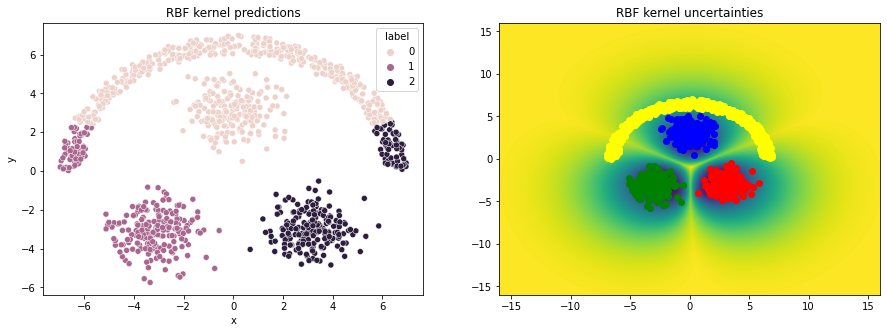

In [27]:
kernel3 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model1b2, ax3 = gaussian(df1b, kernel3, 'RBF kernel')
plt.show()

Since we only used in-distribution data to train the model, and the in-distribution data is the same as in 1a, we did not observe any differences from this model's predictive uncertainties as compared to in 1a).

Testing case 1c

execution time: 2.07881015141805 mins


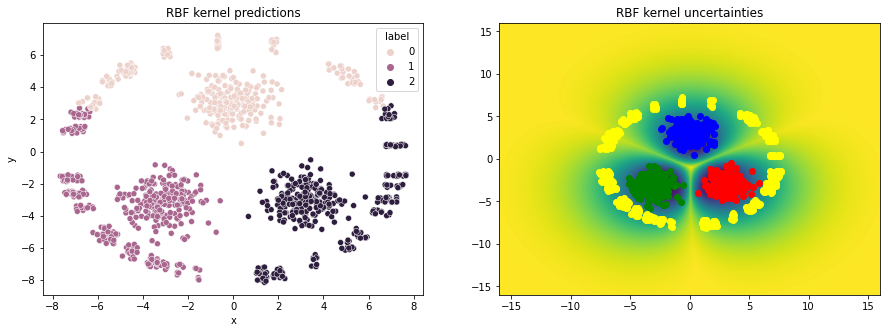

In [28]:
model1c2, ax3 = gaussian(df1c, kernel3, 'RBF kernel')
plt.show()

Since we only used in-distribution data to train the model, and the in-distribution data is the same as in 1a, we did not observe any differences from this model's predictive uncertainties as compared to in 1a) and 1b).

Testing case 2a

execution time: 1.983276935418447 mins


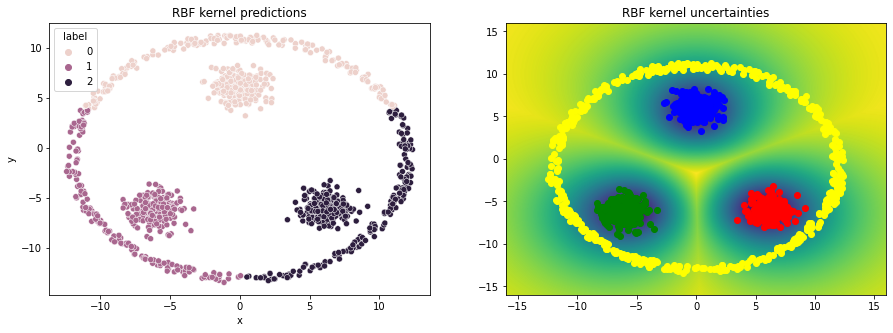

In [29]:
model2a3, ax3 = gaussian(df2a, kernel3, 'RBF kernel')
plt.show()

As circles moved away from each other, we observe that the shape of the uncertainty clusters and decision boundaries remain the same. 

Testing case 2b

execution time: 1.9705460707346598 mins


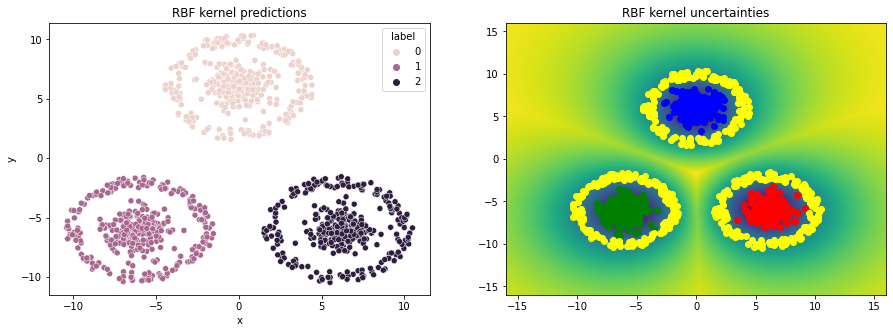

In [30]:
kernel3 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model2b2, ax3 = gaussian(df2b, kernel3, 'RBF kernel')
plt.show()

Since the in-distribution data, which we trained upon, didn't change from the 2a) case, we still observe the same pattern. The model feels fairly certain about the OOD data, as they are still very separated and close to the in-distribution data. This behavior is expected as a human being would probably make the same decision in a case like this.

Testing case 3

execution time: 2.249758279323578 mins
execution time: 2.1515100995699563 mins
execution time: 1.5189783692359924 mins


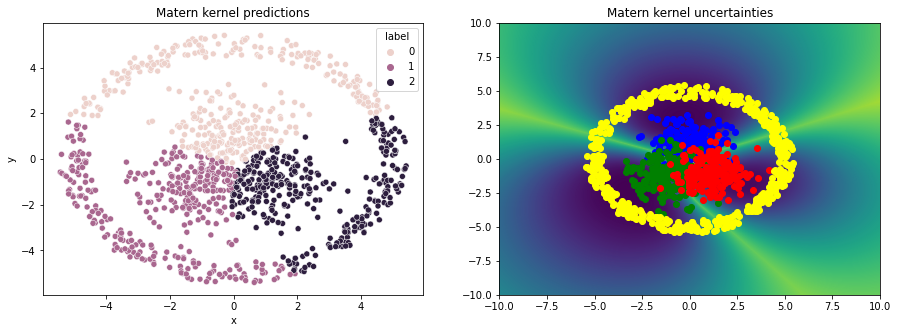

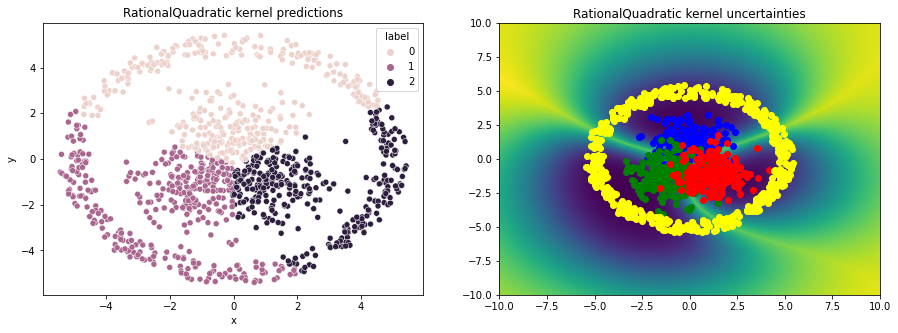

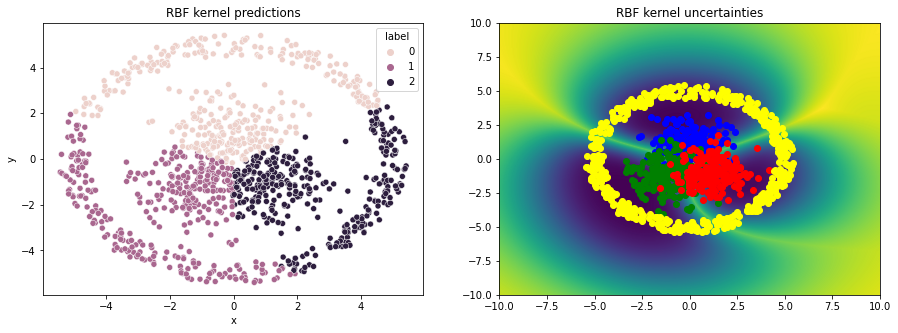

In [31]:
#adjust kernel parameters
kernel1 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.Matern(length_scale=1.0, nu=1.5)
model31, ax1 = gaussian(df3, kernel1, 'Matern kernel', l = 10)
kernel2 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RationalQuadratic(length_scale=1.0, alpha=1.5)
model32, ax2 = gaussian(df3, kernel2, 'RationalQuadratic kernel', l = 10)
kernel3 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model32, ax3 = gaussian(df3, kernel3, 'RBF kernel', l = 10)
plt.show()

In the overlapping case, the model captured the decision boundary fairly well. However, it was still assigning higher certainties to OOD data that lays further away from the decision boundaries. The kernel function didn't change the shape of the distribution, but it did change the speed of decay in certainty as points move further away from training data

Testing case 4

execution time: 0.5084243853886922 mins


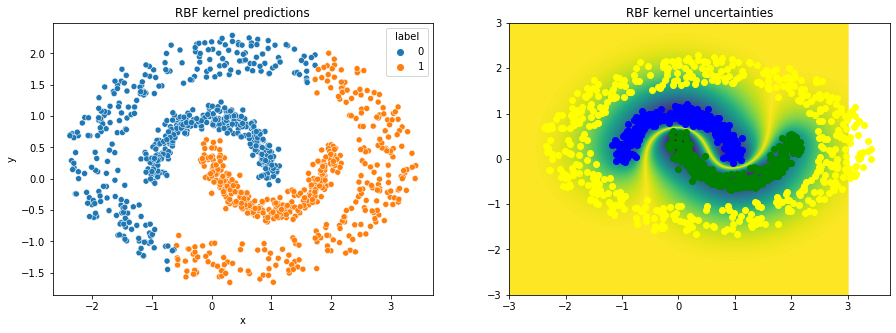

In [32]:
#adjust kernel parameters
kernel3 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model42, ax3 = gaussian(df4, kernel3, 'RBF kernel', l = 3)
plt.show()

We see that the uncertainties closely follow the shapes of the in-distribution pattern. This could potentially incur problems for OOD data that fall in different regions.

Testing the MNIST case

In [33]:
from sklearn.model_selection import train_test_split

In [44]:
l = 16
start = time.time()
#first get train x and train y (without including OOD data)
X_new = np.concatenate((X_0, X_1, X_2))
y_new = np.concatenate((y_0, y_1, y_2))
#split out a 10% validation set
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.1)
#initialize model
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.Matern(length_scale=1.0, nu=1.5)
model = gp.GaussianProcessClassifier(kernel=kernel)
model.fit(X_train, y_train)
print('execution time: {} mins'.format((time.time()-start)/60))

execution time: 0.17903038263320922 mins


In [45]:
#predict with OOD data
y_pred_test = model.predict(X_test)
y_pred_proba_test = model.predict_proba(X_test)

y_pred_proba_OOD = model.predict_proba(X_mnist[:500])

In [46]:
#evaluations
acc = metrics.accuracy_score(y_test, y_pred_test)
print('Test Accuracy: ', acc)
auc = metrics.roc_auc_score(y_test, y_pred_proba_test, multi_class = 'ovo')
print('Test AUC: ', auc)
ind_unc = np.mean(uncertainty(y_pred_proba_test))
print('In distribution uncertainty: ', ind_unc)
ood_unc = np.mean(uncertainty(y_pred_proba_OOD))
print('In distribution uncertainty: ', ood_unc)

Test Accuracy:  0.2866666666666667
Test AUC:  0.5
In distribution uncertainty:  0.6666666666666667
In distribution uncertainty:  0.6569577760976484


### 5.2 Neural Linear Models (NLM)

In this section, we will explore the distribution of the prediction uncertainties of the data using neural linear model(NLM). The general idea of NLM is a neural network model (obtain last hidden layer) + one layer bayesian neural networks. So the code part includes 3 main functions: neural_networks [train nn model + extract the last hidden layer], sampler[sample weights based on the posterior], plot_graph [calculate the uncertainty and plot]. 

The neural networks we used contains 4 hidden layers. We also tried 2 hidden layers and different hidden nodes. Since the data are simple so that we actually do not need too complex models for NLM. Both 4-layer neural networks and 2-layer neural networks have similar results. An example of the experiment is shown in NLM.ipynb. However, in order to compare with BaCOUn, we show the result of 4-hidden-layer model.

The samplers we tried include HMC and NUTS[pymc]. There are some difference in terms of the uncertainty distribution between these two sampler. For HMC, the prediction uncertainty of the data points that between two classes is narrower. Generally, the uncertainty is smaller using HMC sampler. For detail, please see NLM.ipynb. We use pymc here as it runs faster.

In terms of bayesian part, if we assume weights has normal distribution, the log posterior should be like following:

$W \sim \mathcal{N}(0, 5^2 \mathbf{I}_{D\times D})$
$$\log \left[p(\mathbf{W})\prod_{n=1}^N p(Y^{(n)} |\mathbf{X}^{(n)} , \mathbf{W}) \right] = \log \left[\mathcal{N}(\mathbf{W}; 0, 5^2 \mathbf{I}) \prod_{n=1}^N softmax(WX^n)[y^n] \right]  = \log \left[  \prod_{n=1}^{D} \frac{1}{\sqrt{2\pi}5} \exp(-\frac{1}{2}(\frac{w_n}{5})^2) * \prod_{n=1}^N softmax(WX^n)[y^n]\right]  = \sum_{n=1}^{N} \log{(softmax(WX^n)[y^n])} + D* \log{\frac{1}{\sqrt{2\pi}5}} +(-\frac{1}{50} \sum_{n=1}^{D} w_n^2)$$

Uncertainty: We use the variance of the predicted probability to indicate uncertainty. The prediction uncertainties for in-distribution data and ood data are both calculated. 

In [23]:
import numpy as np
import keras
from keras import layers
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from scipy.special import softmax
from autograd import grad
import theano
import autograd.numpy as np
import pymc3 as pm
import theano.tensor as T
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(12, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

def NN(data, input_shape, nc, batch_size, epochs, loss):
    # separate data
    x_train, x_test, y_train, y_test = train_test_split(data[['x','y']], data['label'], test_size=0.3, 
                                                        stratify = data['label'], random_state=0)
    x_train = np.array(x_train)
    y_train = np.array(pd.get_dummies(y_train))
    x_test = np.array(x_test)
    y_test = np.array(pd.get_dummies(y_test))
    print("Shape of data: ", x_train.shape,y_train.shape, x_test.shape,y_test.shape)
    # train the model  
    batch_size = batch_size
    epochs = epochs
    
    model = make_model(input_shape=input_shape, num_classes=nc)
    model.compile(loss = loss, optimizer="adam", metrics=["accuracy"])
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1,verbose=0)
    # evaluation 
    score = model.evaluate(x_test, y_test, verbose=0)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])
    pred = model.predict(x_test)
    print(pred.shape)
    auc = roc_auc_score(y_test, pred)
    print("AUC: ", auc)
    return model 

def softmax1(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1)[:,None]
def plot_graphs(data,samples,model,xs = [-8,8],ys = [-8,8],aad = [0,0],nc =3):

    #create linespace
    x_linespace = np.linspace(xs[0], xs[1], 100)
    y_linespace = np.linspace(ys[0], ys[1], 100)
    dd_linespace = [[a, b] for a in x_linespace for b in y_linespace] 
    df_linespace = pd.DataFrame(dd_linespace,columns = ['x','y'])

    #construct feature space
    intermediate_layer_model = keras.Model(inputs=model.input,
                                        outputs=model.get_layer(index = 4).output)


    linespace_output = np.array(intermediate_layer_model(df_linespace[['x','y']].values))
    linespace_withc = np.hstack((linespace_output,np.ones((linespace_output.shape[0],1),dtype = linespace_output.dtype)))

    #predict label for each point on linespace
    rand_samples = samples #[:700] #changed depending on sample!!!!!
    all_preds = []
    for W in rand_samples:
        V = softmax1(linespace_withc @ np.array(W).reshape((-1,nc)))
        all_preds.append(V)

    #assign predicted labels
    df_linespace['label'] = np.argmax(np.mean(all_preds,axis = 0),axis = 1)

    #assign uncertainty (using variance)
    mean_label = df_linespace['label']
    varss = np.var(all_preds,axis = 0)
    df_linespace['var']= [varss[i][mean_label[i]] for i in range(len(varss))]
    df_linespace['var'] = [a+aad[1] if a> aad[0] else a for a in df_linespace['var']]
    df_linespace['var'] = df_linespace['var'].fillna(0)
    # mesh grid
    X, Y = np.meshgrid(x_linespace, y_linespace)
    
    plt.figure(figsize = (16,8))
    plt.subplot(1,2,1)
    plottt = df_linespace.pivot("y","x", "label")
    plt.contourf(X,Y,plottt.values)
    df1a = data
    plt.scatter(df1a[df1a['label']==1]['x'],df1a[df1a['label']==1]['y'], color = 'green')
    plt.scatter(df1a[df1a['label']==0]['x'],df1a[df1a['label']==0]['y'], color = 'blue')
    plt.scatter(df1a[df1a['label']==2]['x'],df1a[df1a['label']==2]['y'], color = 'red')
    plt.title('Classifications')
    plt.xlim([xs[0],xs[1]])
    plt.ylim([ys[0],ys[1]])

    plt.subplot(1,2,2)
    plottt = df_linespace.pivot("y","x", "var")
    plt.contourf(X,Y,plottt.values)
    plt.scatter(df1a[df1a['label']==1]['x'],df1a[df1a['label']==1]['y'], color = 'green')
    plt.scatter(df1a[df1a['label']==0]['x'],df1a[df1a['label']==0]['y'], color = 'blue')
    plt.scatter(df1a[df1a['label']==2]['x'],df1a[df1a['label']==2]['y'], color = 'red')
    plt.title('Uncertainty')
    plt.xlim([xs[0],xs[1]])
    plt.ylim([ys[0],ys[1]])
    return linespace_output,plottt.values

In [38]:
def neural_networks(data, input_shape, nc, batch_size, epochs, loss):
    model = NN(data, input_shape, nc, batch_size, epochs, loss)
    # The last hidden layer ---> index = 4
    intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer(index = 4).output)
    # feature map
    intermediate_output = np.array(intermediate_layer_model(data[['x','y']].values))
    return model, intermediate_layer_model, intermediate_output
def sampler(data,nc,model,intermediate_output,Priord,xs = [-8,8],ys = [-8,8]):
    D = nc * (intermediate_output.shape[1] + 1) 
    x = intermediate_output
    y = data['label'].values
    x_with_constant = np.hstack((x, np.ones((x.shape[0], 1), dtype=x.dtype)))
    with pm.Model() as bayesian_model:
        #define priors
        W = pm.Normal('W', mu=0, tau=1./(Priord**2), shape= D)

        p = pm.math.dot(x_with_constant, W.reshape((-1,nc))) 

        #softmax
        theta = T.nnet.softmax(p)
        #define binomial likelihood
        y_obs = pm.Categorical('y_obs',  p=theta, observed=y)
        step = pm.Metropolis()
        trace = pm.sample(5000,step,tune = 10000,chains = 2)
    thinned_trace = trace[::1]['W']
    _,pp = plot_graphs(data,thinned_trace,model,xs=xs,ys=ys,nc=nc)

#### 1. Well-Seperated and Linearly-Seperatable data

In part 4.1, it contains three different OOD data with different shapes. The in-distribution data are all the same. Because NLM only use in-distribution data to train the model, so the result should apply to all three cases.

Shape of data:  (420, 2) (420, 3) (180, 2) (180, 3)
Test loss: 0.0011955087538808584
Test accuracy: 1.0
(180, 3)
AUC:  1.0
(600,)


Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [W]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:09<00:00, 3132.48draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


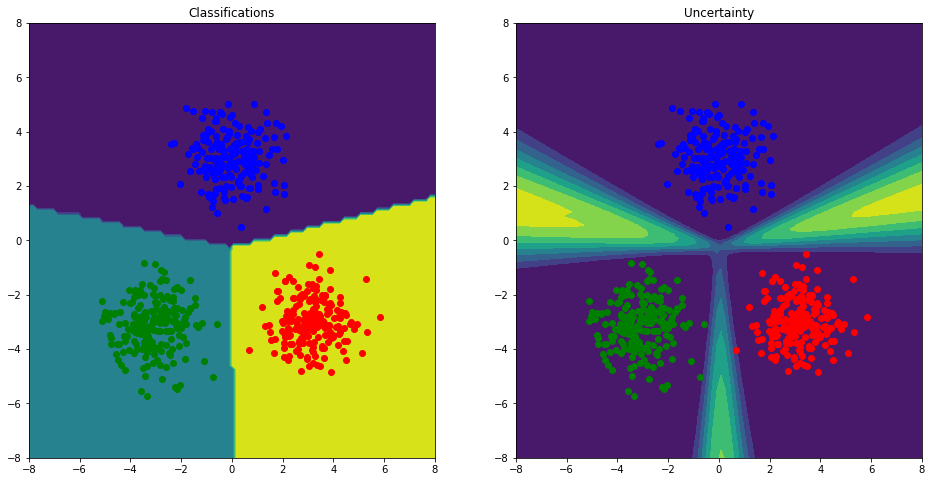

In [31]:
data = df1a[df1a.label!='OOD']
model, intermediate_layer_model, intermediate_output =  neural_networks(data, 2, 3, 32, 15, "categorical_crossentropy")
sampler(data,3,model,intermediate_output,1)

(600,)


Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [W]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:17<00:00, 1706.53draws/s]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


(600,)


Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [W]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:12<00:00, 2466.41draws/s]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


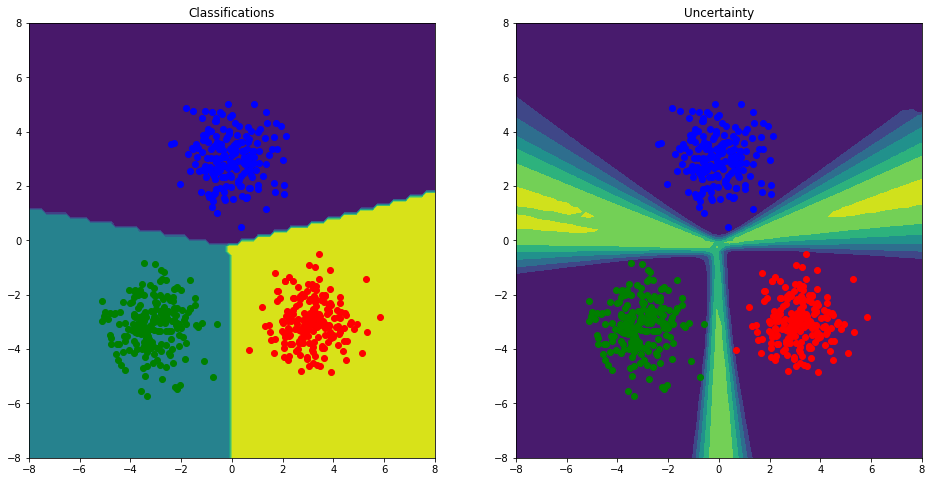

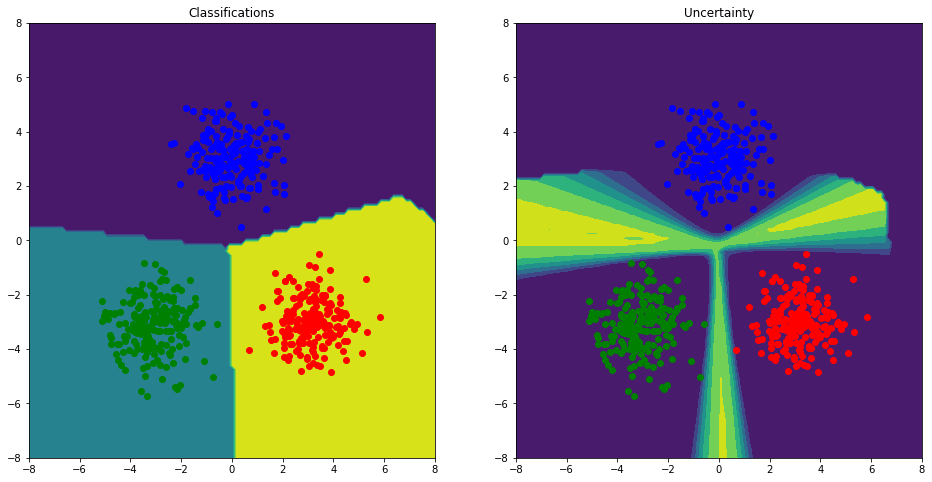

In [32]:
sampler(data,3,model,intermediate_output,5)
sampler(data,3,model,intermediate_output,10)

These six plots show the result of classification and uncertainty with different bayesian priors (1,5,10). For classification, since the data is well seperated, NLM can easily seperate them with linearly boundary. However, since NLM does not consider the boudary of the data, so the uncertainty is also linearly bounded. The bad thing is for the data points in the upper part, left and right corner, we may want the uncertainty to be high, but it is pretty low now. This may lead some practical problems since it can not tell all OOD points apart.

Shape of data:  (420, 2) (420, 3) (180, 2) (180, 3)
Test loss: 0.00045383034739643335
Test accuracy: 1.0
(180, 3)
AUC:  1.0
(600,)


Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [W]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:20<00:00, 1480.05draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


(600,)


Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [W]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:13<00:00, 2295.01draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


(600,)


Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [W]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:18<00:00, 1612.51draws/s]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


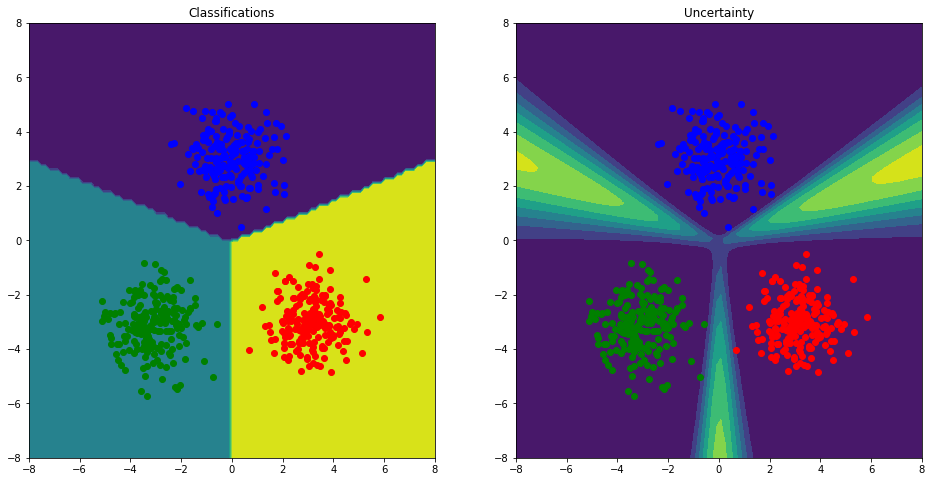

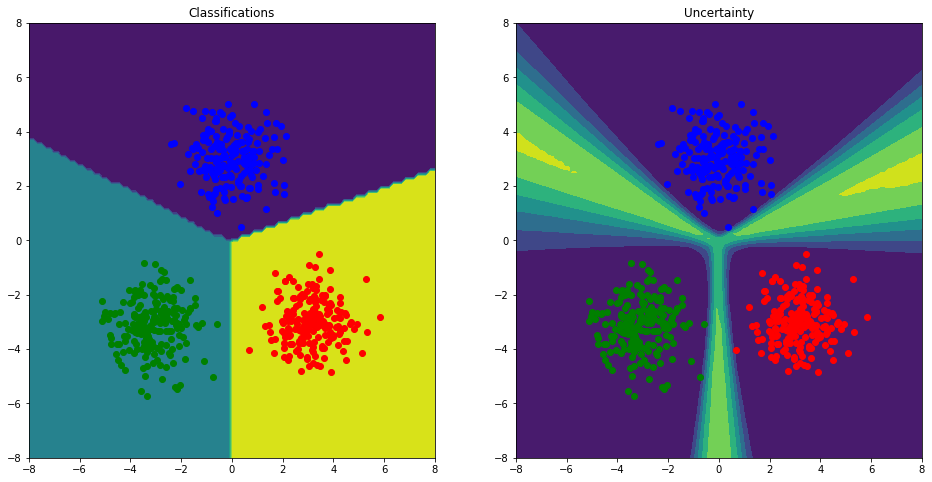

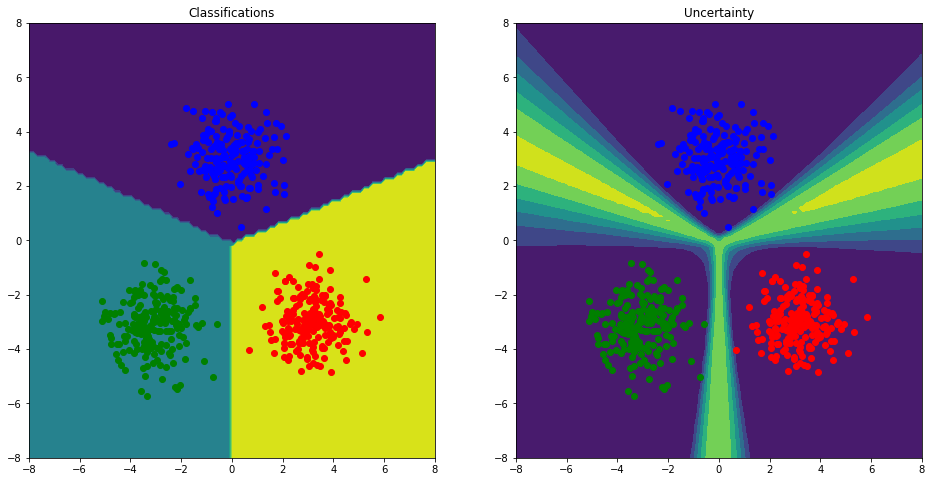

In [33]:
# data with semicircle OOD points
data = df1b[df1b.label!='OOD']
model, intermediate_layer_model, intermediate_output =  neural_networks(data, 2, 3, 32, 15, "categorical_crossentropy")
sampler(data,3,model,intermediate_output,1)
sampler(data,3,model,intermediate_output,5)
sampler(data,3,model,intermediate_output,10)

Since the training data is all the same, data with semicircle OOD points has similar results as first part. We can also see that as the bayesian prior changes, specifically, the variance of parameters increases, the uncertainty also increases.

#### 2. Well-Seperated but clusters are far away from each other

In part 4.2, it contains two different OOD data with different shapes. The in-distribution data is all the same. Because NLM only use in-distribution data to train the model, so the result should apply to both cases.

Shape of data:  (420, 2) (420, 3) (180, 2) (180, 3)
Test loss: 0.00013482246140483767
Test accuracy: 1.0
(180, 3)
AUC:  1.0
(600,)


Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [W]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:20<00:00, 1497.64draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


(600,)


Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [W]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:20<00:00, 1453.58draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


(600,)


Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [W]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:13<00:00, 2180.99draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


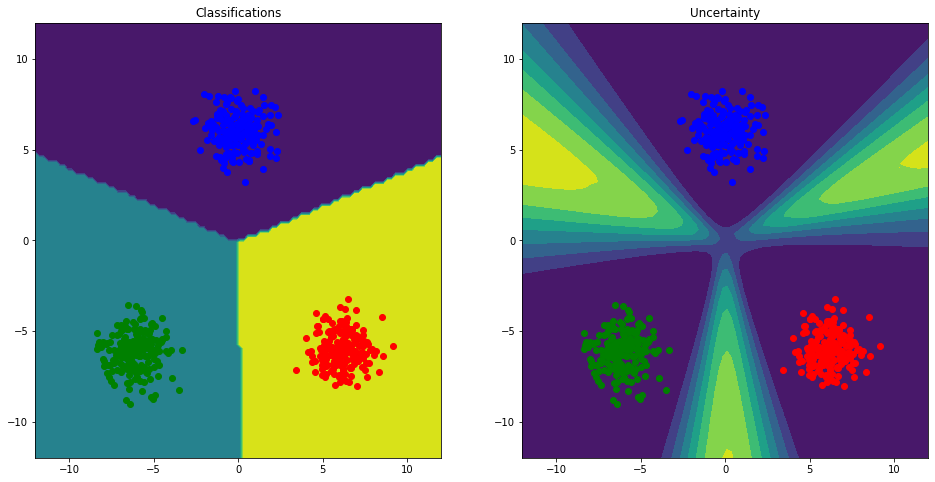

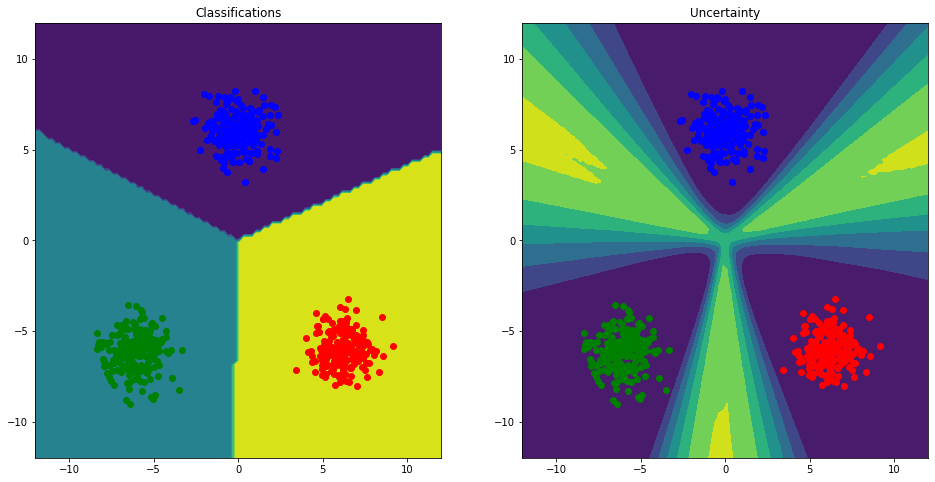

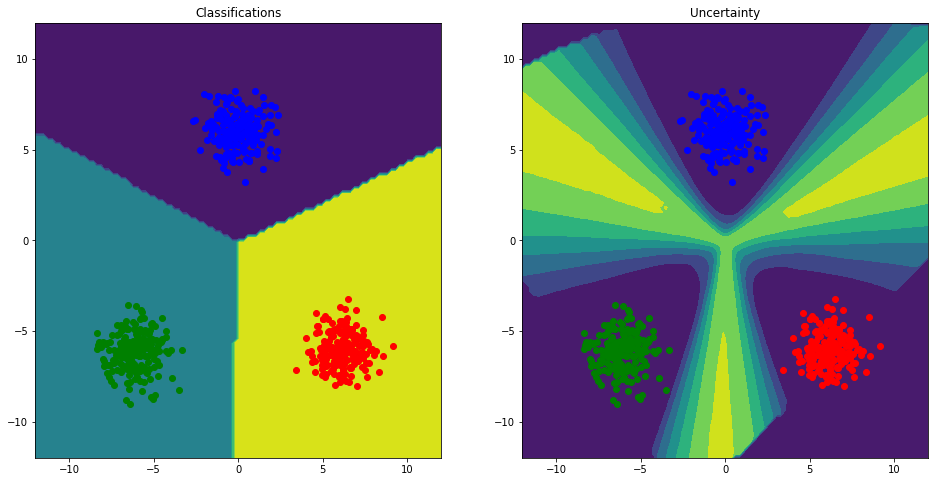

In [35]:
data = df2a[df2a.label!='OOD']
model, intermediate_layer_model, intermediate_output =  neural_networks(data, 2, 3, 32, 15, "categorical_crossentropy")
sampler(data,3,model,intermediate_output,1,xs = [-12,12],ys = [-12,12])
sampler(data,3,model,intermediate_output,5,xs = [-12,12],ys = [-12,12])
sampler(data,3,model,intermediate_output,10,xs = [-12,12],ys = [-12,12])

Same as part 1, NLM can well classified the data and has a "Y" shape for high uncertainty region. The biggest difference is that the uncertain area is larger and  wider with higher value, which makes sense since the clusters are far away from each other so the uncertainty is higher in the inter-class region.

#### 3. Not Well-Seperated

Shape of data:  (420, 2) (420, 3) (180, 2) (180, 3)
Test loss: 0.44605177640914917
Test accuracy: 0.8222222328186035
(180, 3)
AUC:  0.9491666666666667
(600,)


Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [W]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:14<00:00, 2072.03draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


(600,)


Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [W]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:10<00:00, 2967.72draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


(600,)


Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [W]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:09<00:00, 3036.53draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


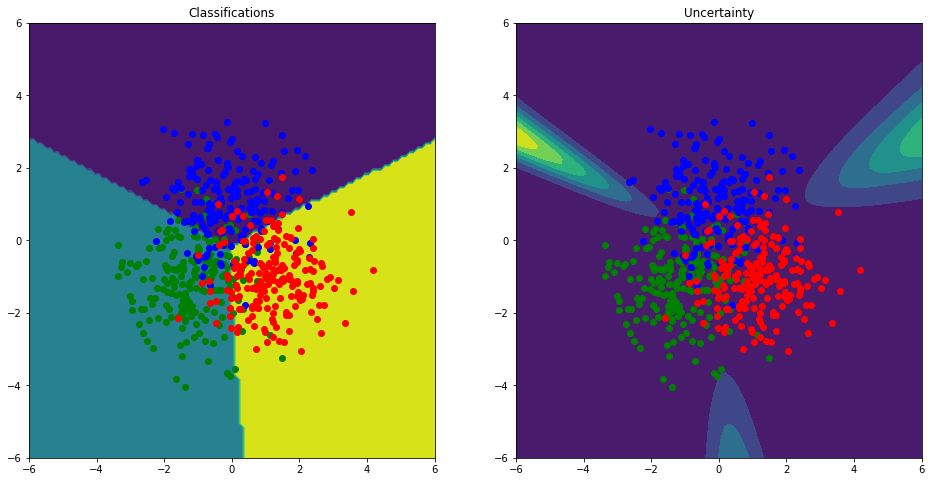

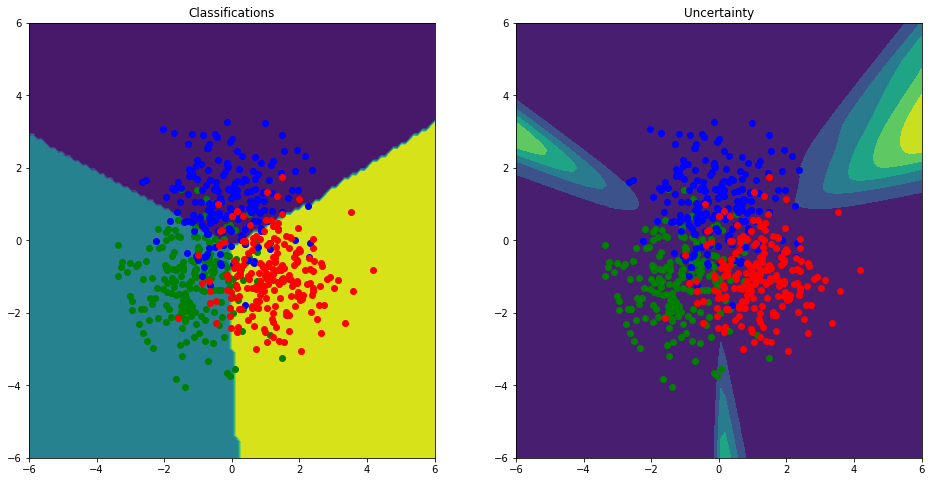

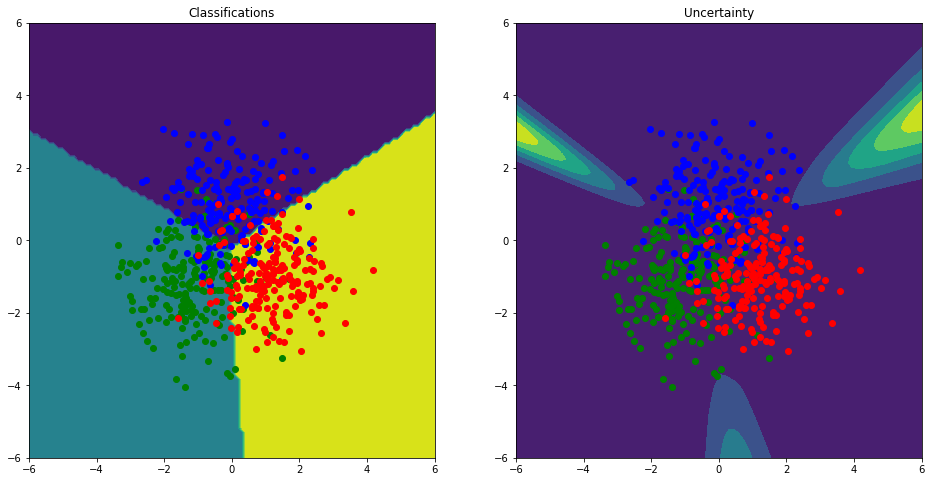

In [36]:
data = df3[df3.label!='OOD']
model, intermediate_layer_model, intermediate_output =  neural_networks(data, 2, 3, 32, 15, "categorical_crossentropy")
sampler(data,3,model,intermediate_output,1,xs = [-6,6],ys = [-6,6])
sampler(data,3,model,intermediate_output,5,xs = [-6,6],ys = [-6,6])
sampler(data,3,model,intermediate_output,10,xs = [-6,6],ys = [-6,6])

These patterns are very interesting. For not well seperated data, the high uncertainty area only includes OOD points that lies on the classification boundary line. Intuitively, we want the overlapped area [center of the figure] to have high uncertainty. But with NLM, it is hard to catch that intuition. I personally think that changing the model hyperparameters may increase the uncertainty for the overlapped area.

#### 4.  Non-Linear Boundary

Shape of data:  (420, 2) (420, 2) (180, 2) (180, 2)
Test loss: 0.09549206495285034
Test accuracy: 0.9611111283302307
(180, 2)
AUC:  0.9974074074074074


Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [W]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:08<00:00, 3354.46draws/s]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [W]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:12<00:00, 2460.77draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [W]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:09<00:00, 3192.83draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


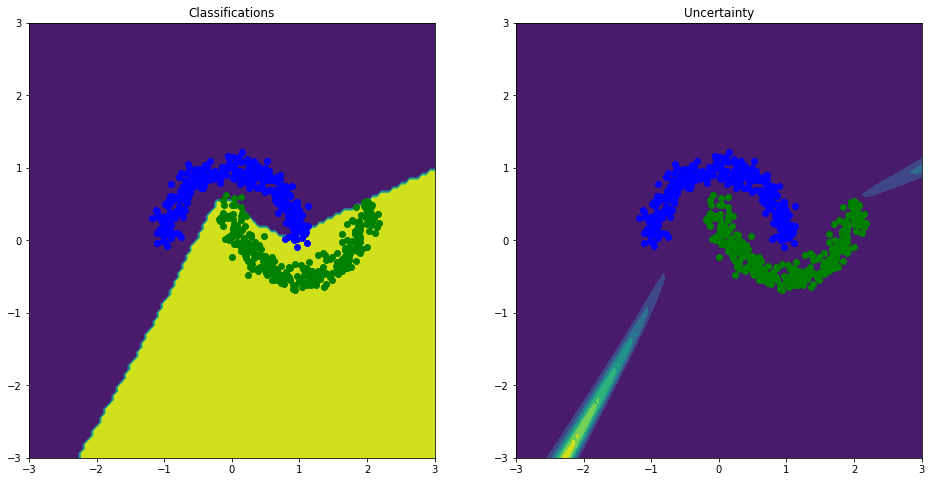

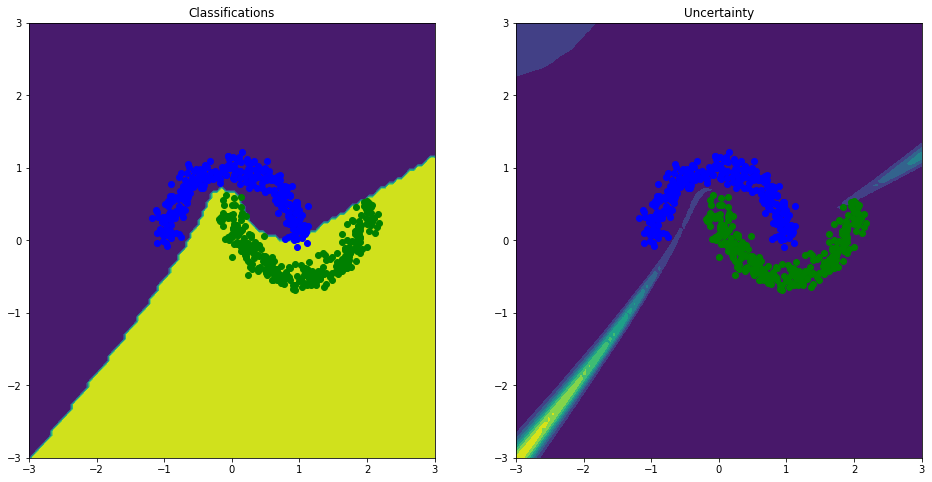

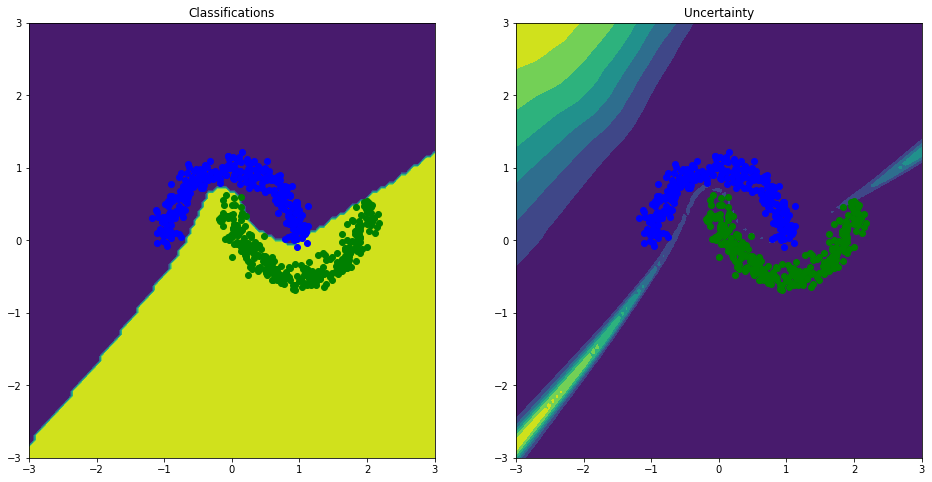

In [39]:
data = df4[df4.label!='OOD']
model, intermediate_layer_model, intermediate_output =  neural_networks(data, 2, 2, 32, 15, "categorical_crossentropy")
sampler(data,2,model,intermediate_output,1,xs = [-3,3],ys = [-3,3])
sampler(data,2,model,intermediate_output,5,xs = [-3,3],ys = [-3,3])
sampler(data,2,model,intermediate_output,10,xs = [-3,3],ys = [-3,3])

From the plots above, we can see that NLM is enough to do classification with non-linear boundary. Also, the high uncertianty areas lie on the decision boudary. When the std of bayesian prior equals 1, the inner part of the in-distribution data has low uncertainty, but when std equals 10, it has higher uncertainty. What's more, there are uncertainties for further OOD points (left upper corner of the last plot) when std is 10.

In [ ]:
## Workable HMC to calculate the posterior
# import autograd.numpy as np
# nc = 3 # 3 classes
# D = nc * (intermediate_output.shape[1] + 1) 
# x = intermediate_output
# y = df1a['label'].values
# N = x.shape[0]
# Priord = 10
# x_with_constant = np.hstack((x, np.ones((x.shape[0], 1), dtype=x.dtype)))

# def log_posterior(W):

#     V_ = softmax1(x_with_constant @ np.array(W).reshape((-1,nc)))
#     term1 = sum([np.log(V_[i][int(y[i])]) for i in range(N)])
#     term2 = D* np.log(1/(Priord*np.sqrt(2*np.pi))) -(1/Priord**2/2)*np.sum(W**2)
#     return term1 + term2 

# # The code is from class exercise 10.20

# D = D #dim
# m = 1 #mass
# M = m * np.eye(D) #mass matrix

# def U(W):
#     return -log_posterior(W)
 
# du_dy = grad(U) #gradient of U wrt to y

# def K(p):
#   # kinetic energy function
#   return 0.5 * p.T @ np.linalg.inv(M) @ p + 0.5 * np.log(np.linalg.det(M)) + 0.5 * D * np.log(2 * np.pi)
# dK_dp = grad(K) #gradient of K wrt p

# def H(y, p):
#   # H(y, p) = U(y) + K(p)
#   return U(y) + K(p)

# def HMC(y_init, num_samples, num_steps, epsilon, burnin, thinning):
#   # initialization
#     samples = [y_init]
#     y_current = y_init
#     accept = 0
#     for s in range(num_samples):
#         # sample a random momentum from the Gibbs distribution of K(p), here is N(0,M)
#         p_current = np.random.multivariate_normal(mean=np.zeros(D),cov=M)
        
#         # leap-frog integrator
#         y_next = y_current
#         p_next = p_current
#         p_next -= 0.5 * epsilon * np.array(du_dy(y_next)) #half-step update for momentum p 
#         for j in range(int(num_steps)):
#             y_next += epsilon * dK_dp(p_next) #full-step update for position y
#             p_next -= epsilon * du_dy(y_next) #full-step update for momentum p 
#         y_next += epsilon * dK_dp(p_next) #full-step update for position y
#         p_next -= 0.5 * epsilon * du_dy(y_next) #half-step update for momentum p 

#         # reverse momentum
#         p_next = -p_next

#         # correction for simulation error
#         alpha = min(1, np.exp(H(y_current, p_current) - H(y_next, p_next)))
#         if np.random.uniform(0, 1) <= alpha:
#             y_current, p_current = y_next, p_next
#             accept += 1
#         samples.append(list(y_current))

#     # burnin and thinning:
#     samples = samples[burnin::thinning]
#     return samples, accept/num_samples

# y_init =np.array(list(model.layers[5].get_weights()[0][:,:nc].flatten())+list(model.layers[5].get_weights()[1][:nc].flatten()))
# #y_init = np.ones((1,27)).flatten()
# num_samples = 800
# num_steps = 50
# epsilon = 1e-3 
# burnin = 100
# thinning = 1


# samples, accept = HMC(y_init, num_samples, num_steps, epsilon, burnin, thinning)

### 5.3 Bayesian Classifers with Out-of-Distribution Uncertainty (BaCOUn)

For this section, we will discuss the performance of BaCOUn in different situations. It includes two parts: 1. Development of model in normal case 2. Model performance for different data distribution. As we use HMC to sample which takes a long time to run, relevant codes are saved in a separate file: BaCOUn.ipynb. 

#### 1. Development of model in normal case

1.1: We started with a neural network with 2 dense layers of nodes [32,8]
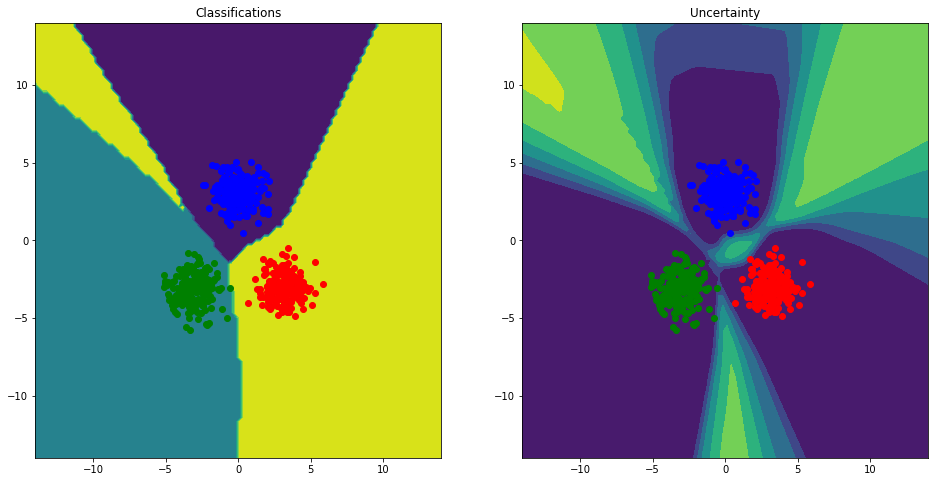

1.2: We started with a neural network with 2 dense layers of nodes [64,8]
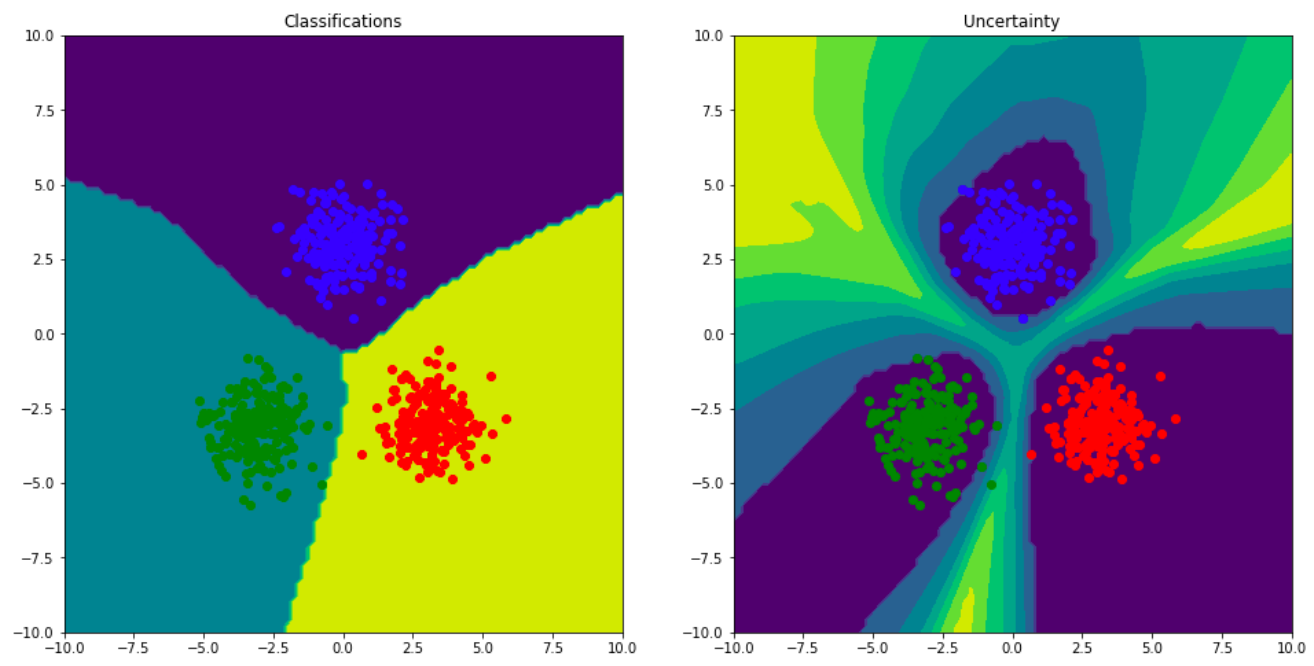

1.3: We started with a neural network with 4 dense layers of nodes [64,32,16,12]
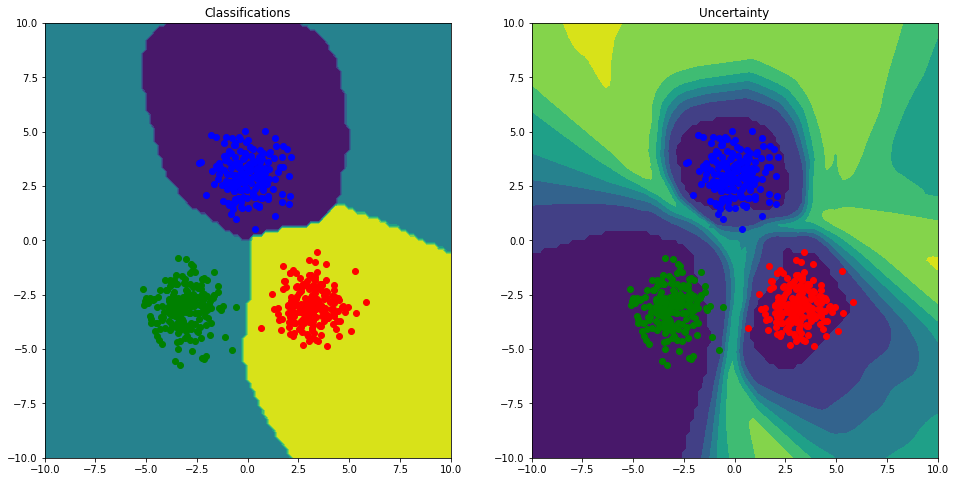

1.4: We started with a neural network with 4 dense layers of nodes [64,32,16,12]. increased prior variation
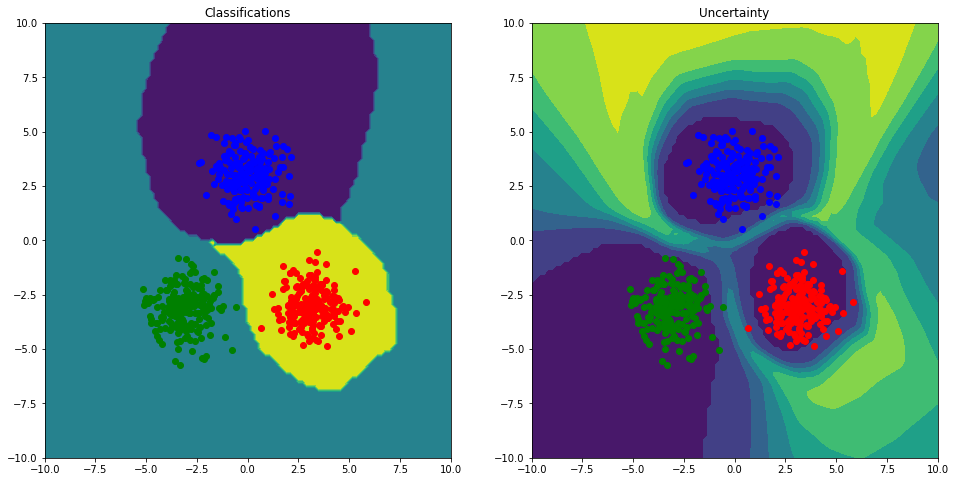

1.5: We started with a neural network with 4 dense layers of nodes [128,64,64,12], increased prior variation
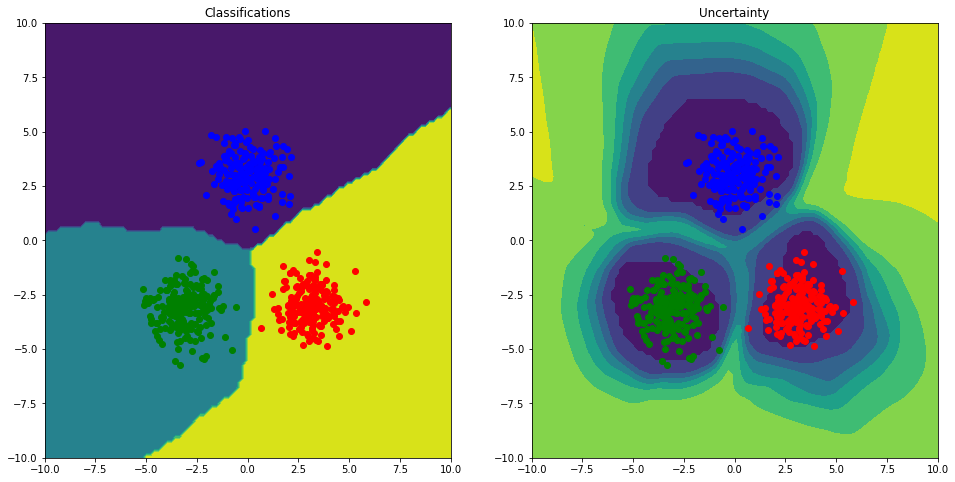

Our first neural network model has a shallow structure and high accuracy, but the uncertainty shape wasn't as good as expected. We then used mainly two ways to test if the model can produce desired uncertainty: 1. increase neural network size 2. increase variation in our prior for weights.
From 1.1 to 1.2, we increase the nodes in NN model, and find that uncertainty was increased, so we further increase the model size from 1.2 to 1.3. We also tested different numbers for the nodes in the final layer, and find that the main improvement rather comes from having NN structure more complex. From 1.3 to 1.4, we increase the prior variance, and the change wasn't obvious. We then increase the model size further, and we get a model with overall desired uncertainty shape. We also repeated our final model for 3 times to ensure that it doesn't come out of chance.


In this process of exploration, we find that whether BaCOUn works well depends on the Neural Network structure. The Neural Network needs to overfit, so that it generated enough uncertainty as desired. The prior variance and number of last layer nodes don't have much influence in our case. The reason might be that they are already large enough and provide enough variance. 


#### 2. Model performance for different data distribution

2.1a: Normal Dara: complete ring

(refer to 1.5)

2.1b: Normal Dara:  semicircle
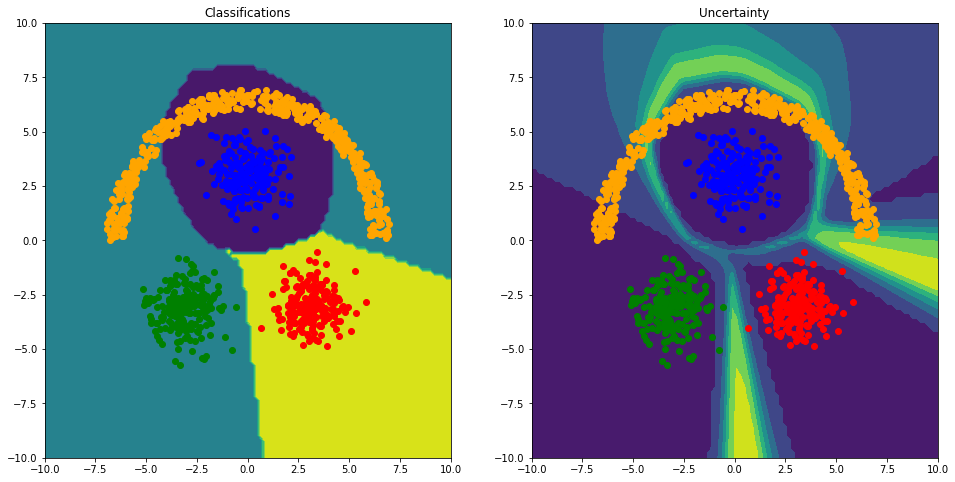

The results from this part is not surprising, as the uncertainty in OOD region mainly comes from having points in OOD region present when training the network. It also reminds us that BaCOUn would only be effective when we identify the OOD region and generate points in these regions.

2.1c: Normal Dara: incomplete OOD (w/ holes)
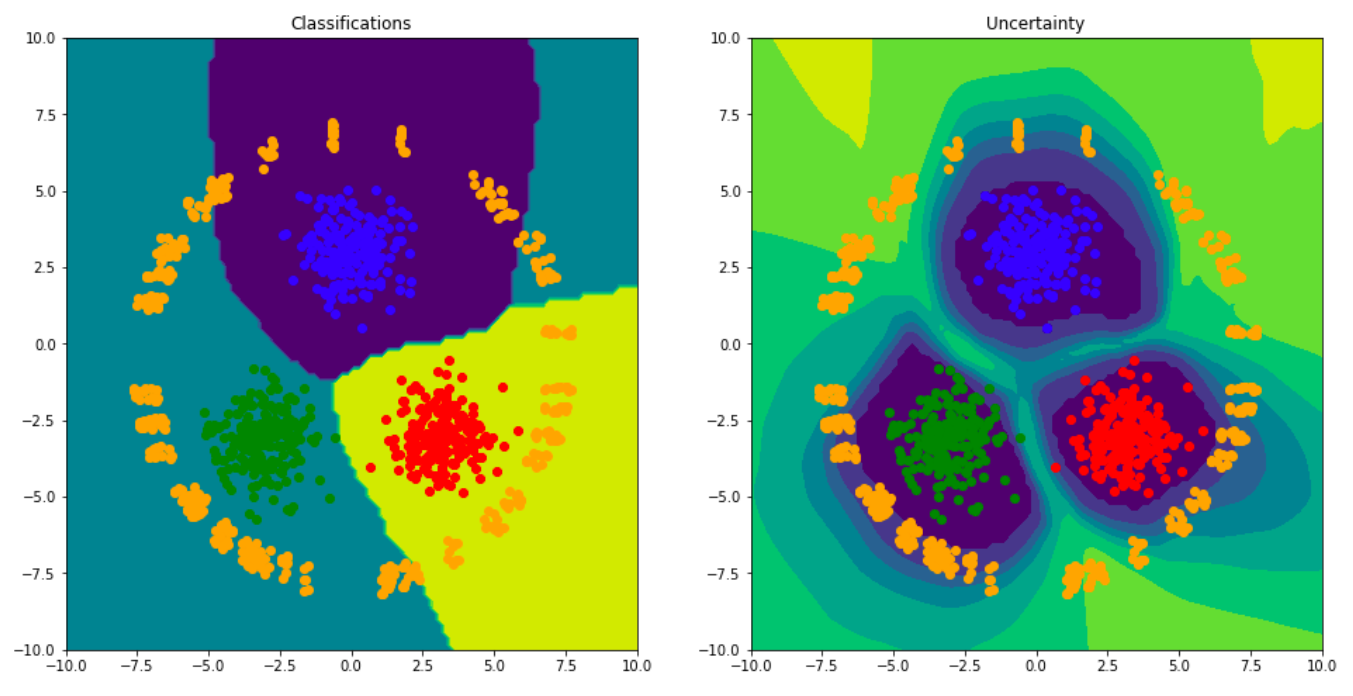

From this result, we see that having holes in OOD region doesn't affect the performance of BaCOUn. It suggests that as long as we have some points in the OOD region, BaCOUn would be effective in predicting uncertainty.


2.2a: Far away distributions: complete ring
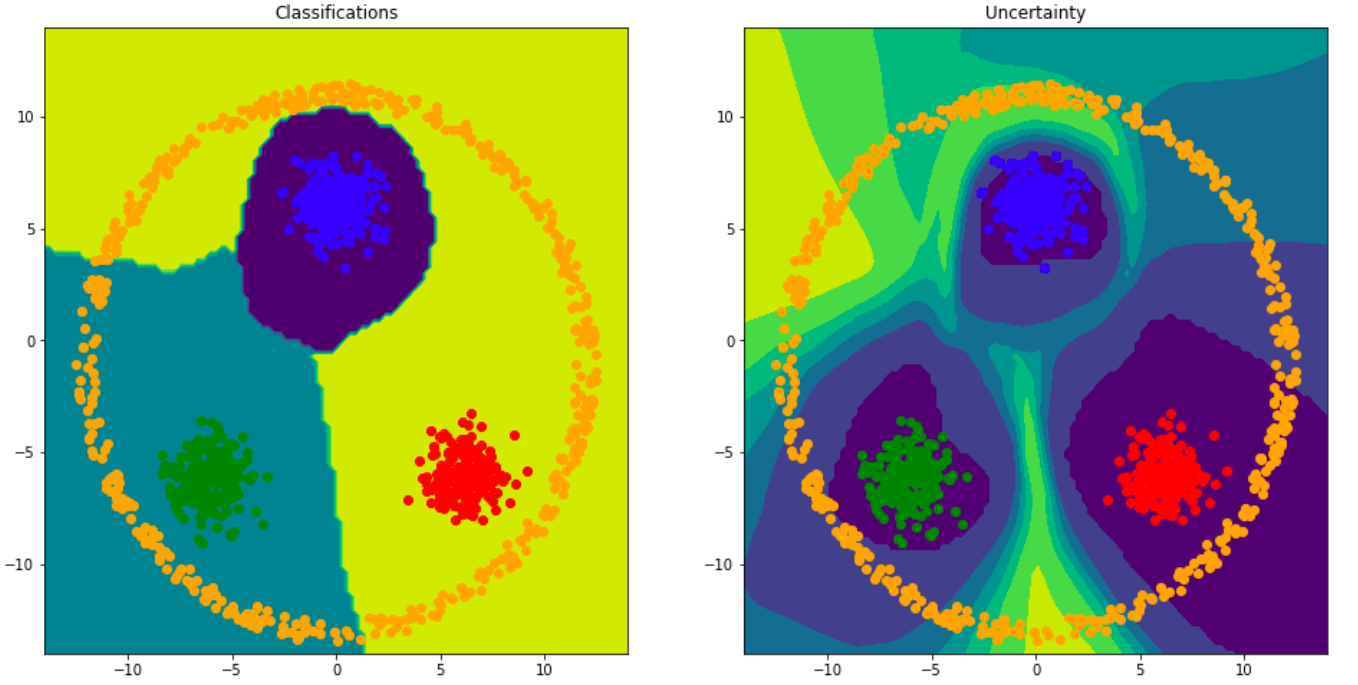

The uncertainty is desired in some OOD regions but not the others. Its shape is very similar to the performance when our NN model structure was shallower. Thus, though we don't see desired uncertainty here, we believe that by making our neural network more complex, the uncertainty predictions would be better.

2.2b: Far away distributions: three ODD boundary
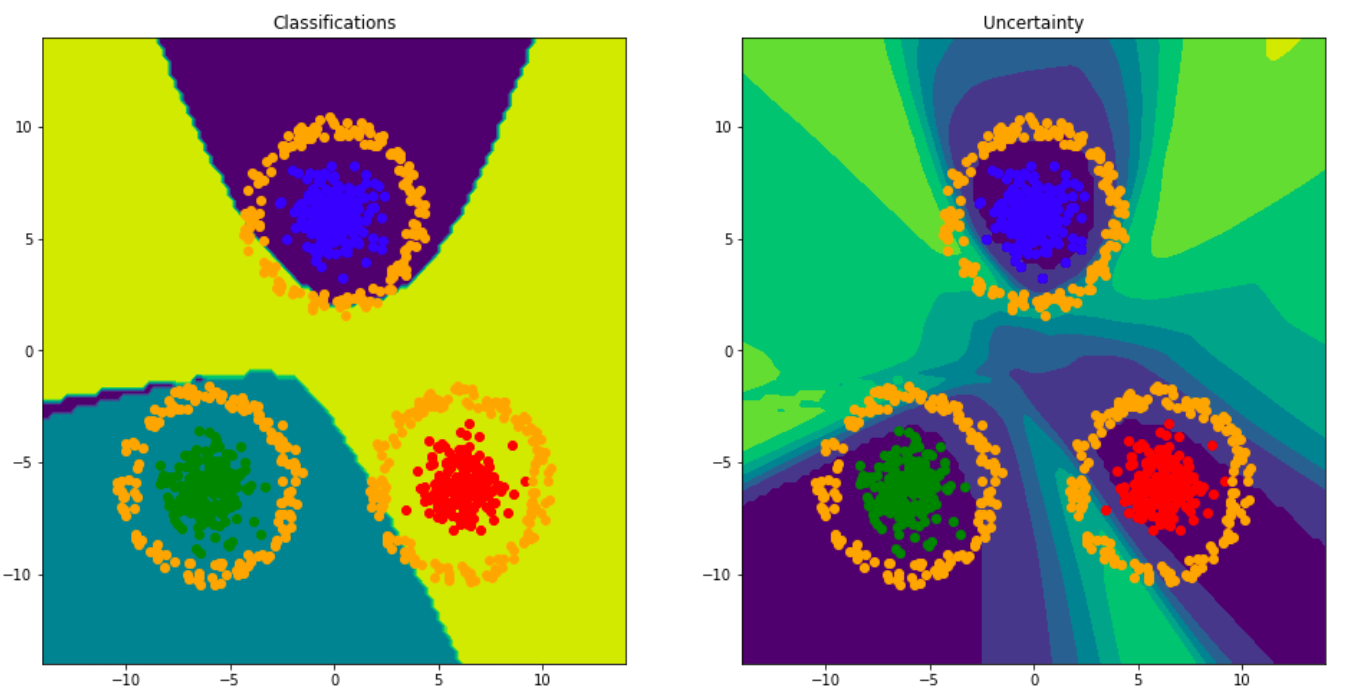

The uncertainty is again not in a desired shape. However, different from the previous case, we here have more uncertainty around the boundaries between distributions and not outside these data distributions (in OOD regions). From this case, we see that the three rings shifted the focus of BaCOUn's uncertainty predictions. It reminds us again how efficient BaCOUn is is highly dependent on the shape and location of OOD points. Also, in this case, we also believe that by having more complex neural network, the OOD uncertainty is likely to be better presented, but it's likely to have less uncertainty then the boundary regions.

2.3: Not Well-Separated: complete ring
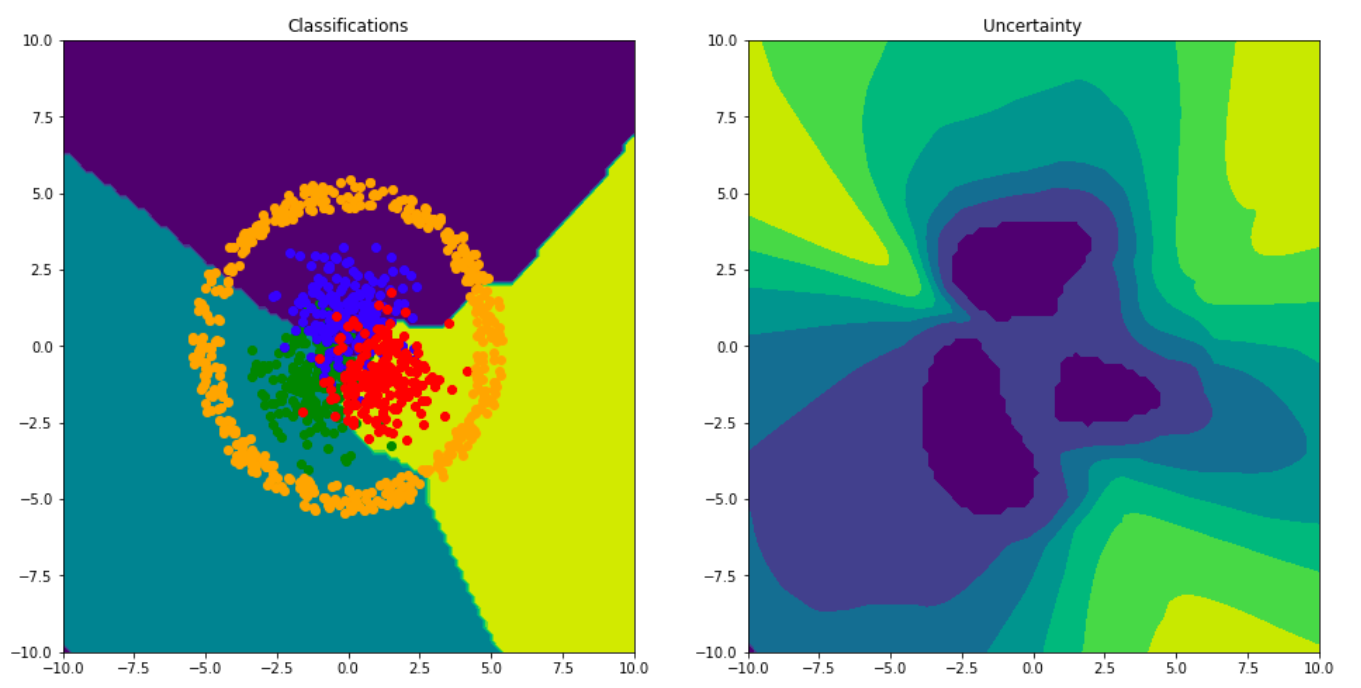
(For better visualization, we didn't plot our points on our uncertainty plot here.)

This shows that BaCOUn is effective even when data is not well-seperated, and will put more uncertainty on OOD regions then boundaries if we use OOD points in the way we do experiment.

2.4:  Well-Separated by non-linear boundary: complete ring
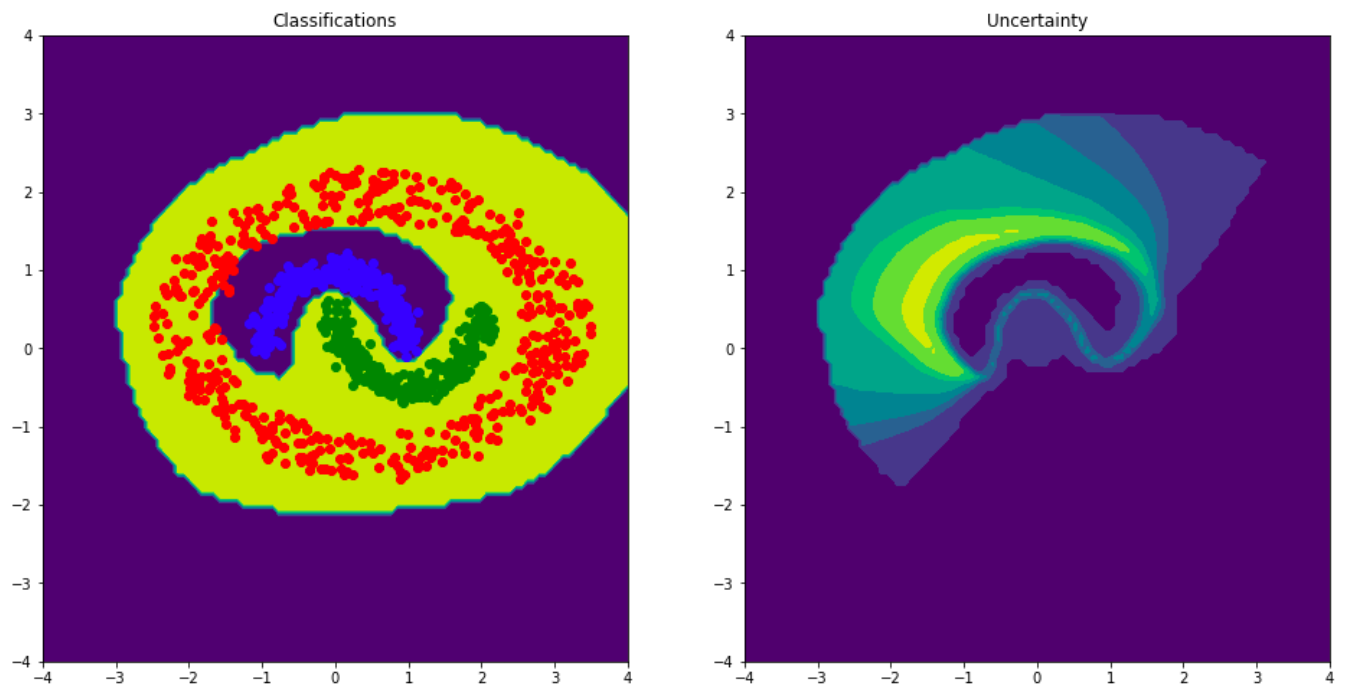
(For better visualization, we didn't plot our points on our uncertainty plot here.)

The model only produce desired uncertainty on one side of the data points. This result might be related to how the NN model is trained. As relatively different data distributions are used here, we are not sure our neural network model here is the best choice. Based on previous experiences, we believe that there exists suitable model structure for BaCOUn to work in this case.

### 5.4 Comparison on MNIST data

| Methods | Test Accuracy | AUC | In-distribution Uncertainty | OOD UNcertainty |
| :- | -: | -: | -: | :-: |
| GP | ? | ? | ? | ? |
| NLM | 0.9800 | 0.9968 | 0.0009 | 0.0125 |
| BaCOUn | 0.9533 | 0.9923 | 1.005e-06 | 6.413e-06 

## 6. Evaluation and Interpretation

### 6.1 Gaussian Processes (GP)

In general, Gaussian Processes' effectiveness on classfying OOD data varies. From the various cases, we could see a general trend: GP is very 'conservative' when it comes to generating uncertainties. The low-uncertainty areas usually follows the shape of the training data very closely. Therefore, when the OOD data is closer to the training data, it would receive relatively lower uncertainties (such as in case 4). This phoenema is a reasonable behavior as humans would also classify points closer to what we have seen with more certainty as well.  

In cases such as 1a, OOD data closer to decision boundaries also received a much larger uncertainty. It is a potential shortcoming that OOD data uncertainty estimation depends a lot on the region where OOD data falls on.

Because we only trained with in-distribution data when constructing the GP model, we could see that the shape of the predictions and uncertainties don't vary as shape of sampled OOD data varies. In practical cases, our generation of OOD data can't always cover the whole domain. So it is a potential advantage that our uncertainty estimation is not very sensitive to OOD data generation.

Changing the kernel, in our cases, doesn't change the shape of decision boundaries and uncertainty clusters. Sometimes it would make uncertainty clusters wider, meaning that it considers a wider diameter around training data to be receiving higher certainties.

Another shortcoming that we saw during GP experiments is that, in case 1a), when we increased the number of classes by one, GP took ~250% more time to train. As number of classes increase, GP don't scale as well.

### 6.2 Neural Linear Models (NLM)

We evaluated the prediction uncertainty using NLM for different data distributions. In general, NLM is good at classification and works well for non-linear boundaries. In terms of uncertainty prediction, NLM is highly rely on the classification boundary. That is, the high uncertain area only lies on the classification boundary and also only lies on the OOD areas.

This is explainable since we use the last hidden layer to train bayesion model. For data points that are labelled the same class, they should have similar hidden layer weights so that the uncertainty for those data points is small. The key problem is that for those OOD points, NLM will also assign a label for them. As a consequence, the uncertainty is small for many OOD regions. We believe that this undesired OOD uncertainty is due to the lack of the information about OOD points in neural networks.

We also find that increasing the variance of bayesian prior can somehow alleviate this problem. This is because by increasing the variance, we has more opportunites to have different weights so that increasing the uncertainty of the results. We reckon that changing the neural network structures, hyperparameters, and bayesian priors can also lead to better results.

Note that there is a warning when we used pymc to sample bayesian parameters. It says that the sampler may not converge and also for some parameters, there are not enough effective samples. We faced same problem in the homework and we found that even though the sampler had not converged, we can still use thses samples to determine uncertainty. Also, we compare the results with HMC sampler. They roughly have same pattern. Another way to solve it is changing the prior and making it realistic. However it's hard for us to determine the accurate priors for our data. Without losing generality, we set prior to be normal distribution with zero mean and std 1, 5, and 10.

### 6.3 Bayesian Classifers with Out-of-Distribution Uncertainty (BaCOUn)

In our exploration, we tested our BaCOUn model in several different cases, both with different model structures and with different OOD distributions. Overall, we find that BaCOUn is always a good model, as long as we have efficient model design and OOD points generated.

An efficient model design, from our exploration, should have much more complex structure than the simple model that predicts data accurately. While the 2-layer model is sufficient in providing accurate predictions, we need a 4-layer model with a large number of nodes at each layer to produce desired uncertainty, and even more complex structures when data distributions are more complex. 

The OOD points generated are significant for BaCOUn to work effectively. As we see in our case, we need our OOD points to cover all OOD regions so that the uncertainty predicted is in a desired shape. However, as long as our OOD points roughly cover the whole OOD region, it doesn't matter whether it's everywhere or not. This gives us some flexibility in OOD generations.

In general, BaCOUn is effective in predicting uncertainties, as long as our neural network is deep enough and our OOD points roughly cover all OOD regions.

Compared to the Gaussian Process which also produce desired uncertainty, BaCOUn is in most cases a better solution in terms of scalability when we know how to generate OOD samples effectively. When we have more complex model structures, the main computation that needs to be increased comes from the training of neural networks. Though we need relatively more complex structures of neural networks in this case, which might take a long time to train, it will not be as bad as using Gaussian Process in general. The sampling parts will not be a big pain. Even when the parameters needed increase, the computation doesn't grow as much as GP which takes $O(n^3)$. 

In terms of effectiveness in producing the desired shape of uncertainty, while NLM is inefficient in all cases, GP and BaCOUn are effective in different cases. As we see from GP results, no matter what shape OOD points are, GP always produce desired shape of OOD uncertainty, especially as shown in case 1b where the OOD points form a semi circle. It suggests that when we don't have good knowledge of OOD regions and are not sure if our generated OOD points cover all OOD regions, GP will be more accurate in its predictions. However, when looking at case 2b, we see the potential of adjusting uncertainty produced by BaCOUn by changing the number of OOD points at different regions. It suggests that when we have good knowledge where OOD regions are, we might produce more customized uncertainty levels through BaCOUn, whether we want more uncertainty around boundaries or in OOD regions.

## 7. Future Work

In general, we find BaCOUn pretty effective in predicting uncertainty, but its performance highly depends on whether we have a deep enough neural network and whether OOD points are effective. The main future work would be about exploring how to have all these conditions satisfied when we cannot visualize our distributions. There are mainly 3 directions.

1. **Produce effective visualization:**
We experience the problem of visualization when training and comparing with MNIST data. Though using PCA we can have some visualizations, we cannot know how effective our OOD points are, and thus not a good comparison of model performance in predicting uncertainty. This is a general problem, not only for ensuring model performance of BaCOUn, but also other models when dealing with high-dimensional datasets.

2. **Explore generally how deep NN should be to produce effective uncertainty:**
While we find that the effective NN structure would be much wider and deeper than the basic model that predicts accurately, we wonder how much wider and deeper in general should NN be more than the basic case. If such relationships can be discovered and quantified, it will be easier for researchers to use BaCOUn, especially with more complex datasets.

3. **How to ensure OOD samples effectively cover the OOD region:**
This is also an area that benefits lots of research areas besides use of BaCOUn. In our case, as we can visualize data, we don't struggle much with generating good OOD points. However, it might be a problem with more complex datasets.

## 8. References